# Inspection of the U-Net Outputs

This code is designed to load a pre-trained U-Net model, run it on a randomly selected image from the Cityscapes-style semantic segmentation dataset, and visualize both intermediate feature maps and the final prediction.

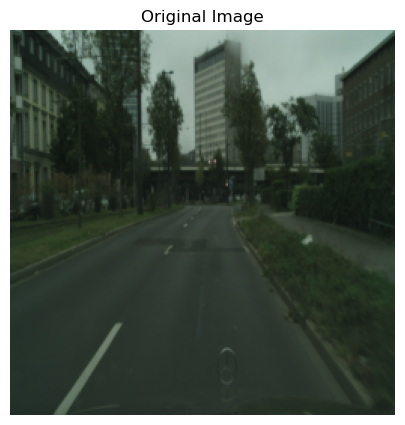

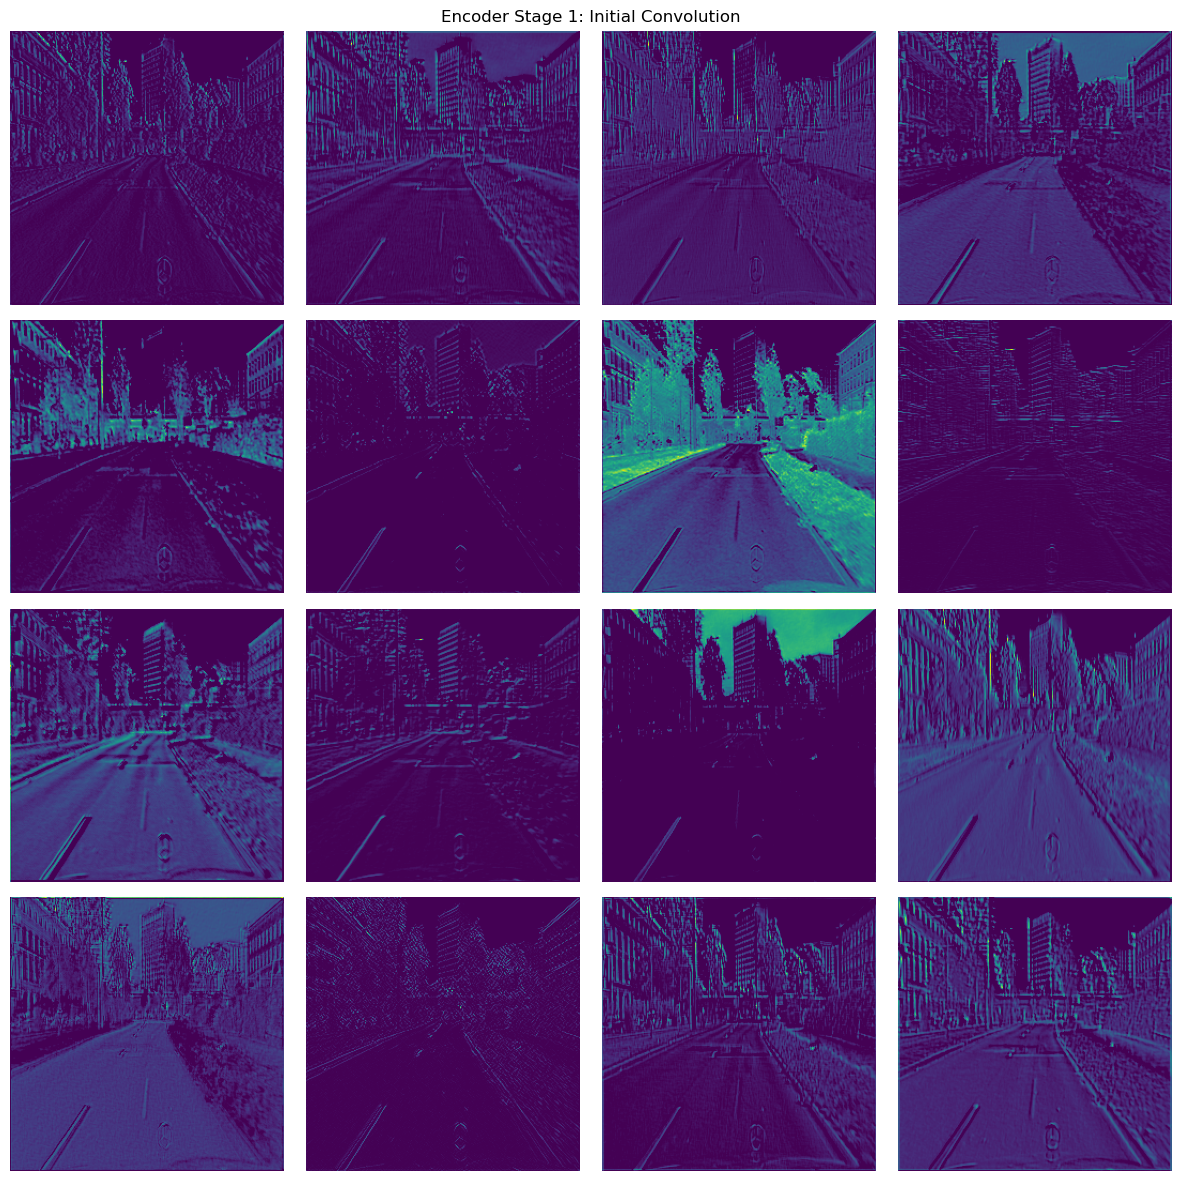

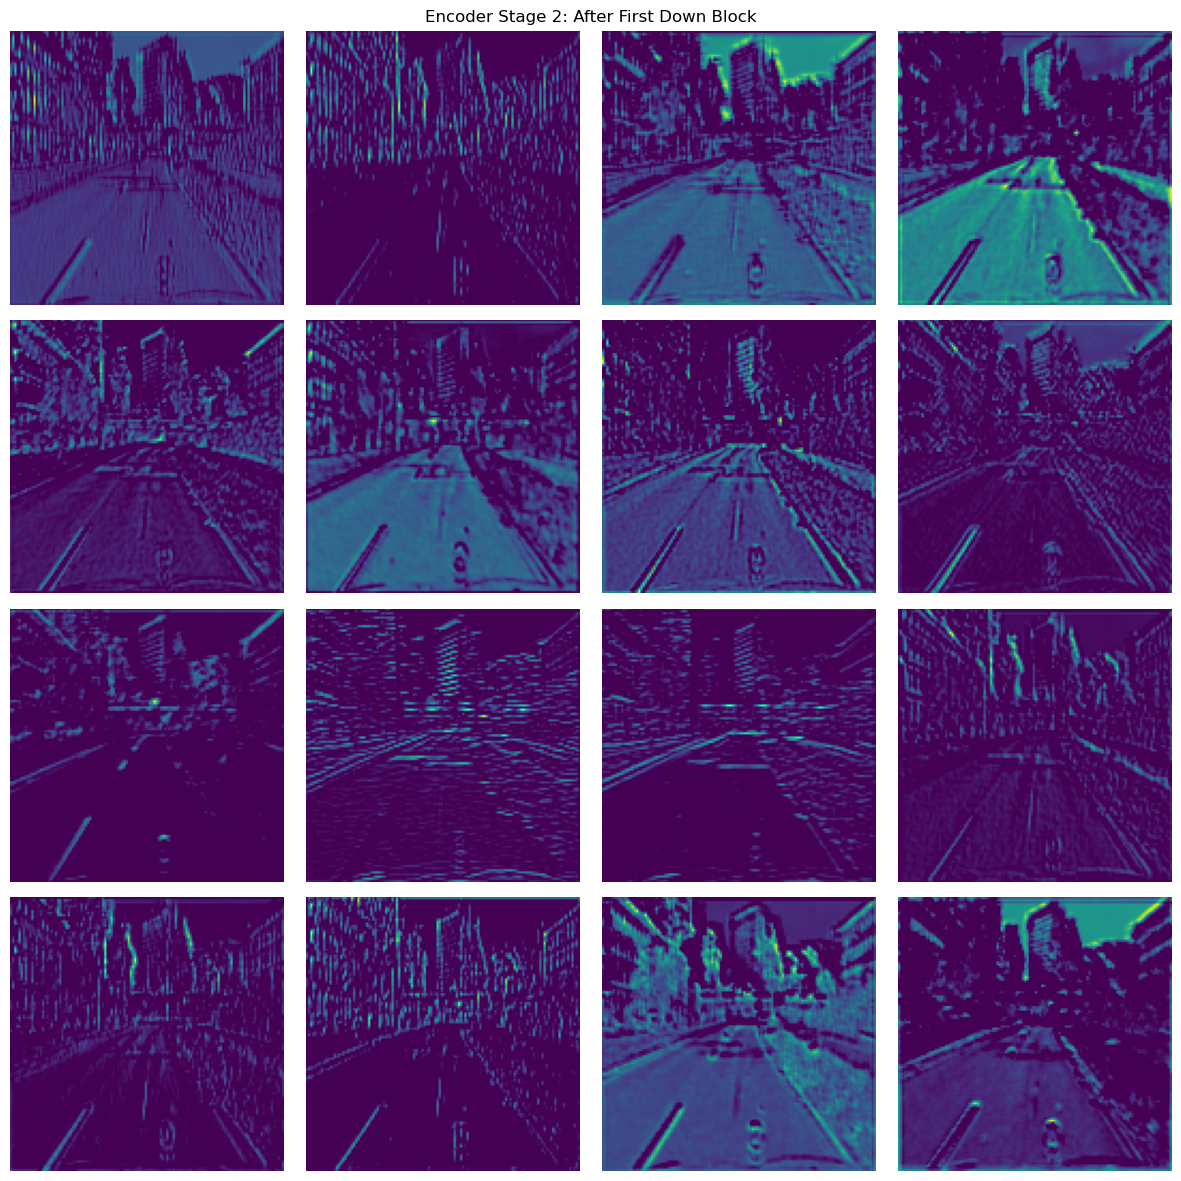

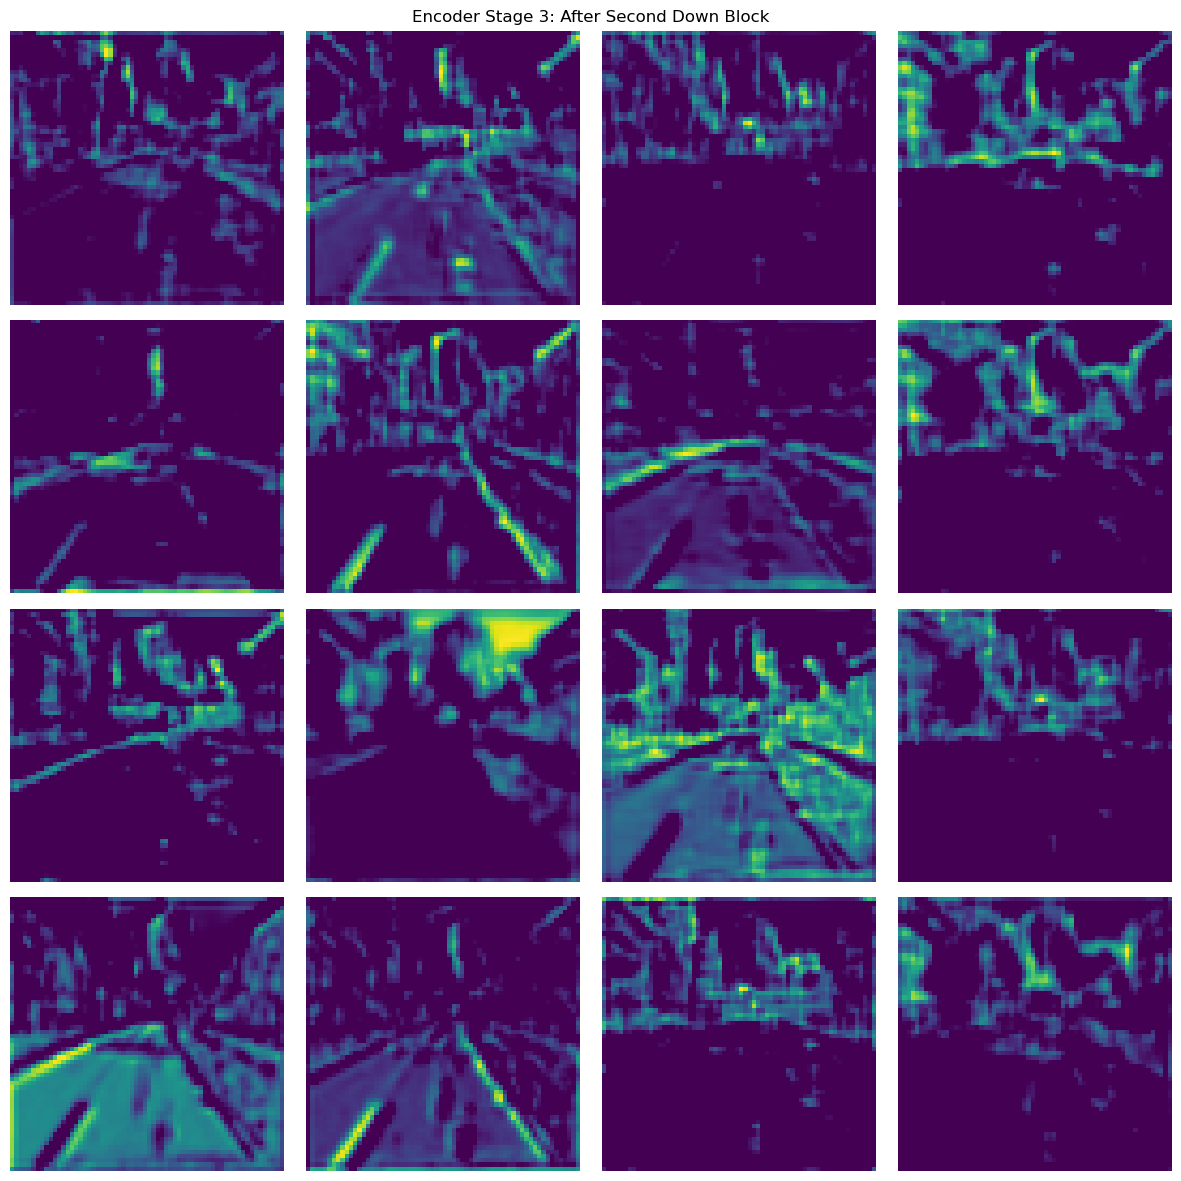

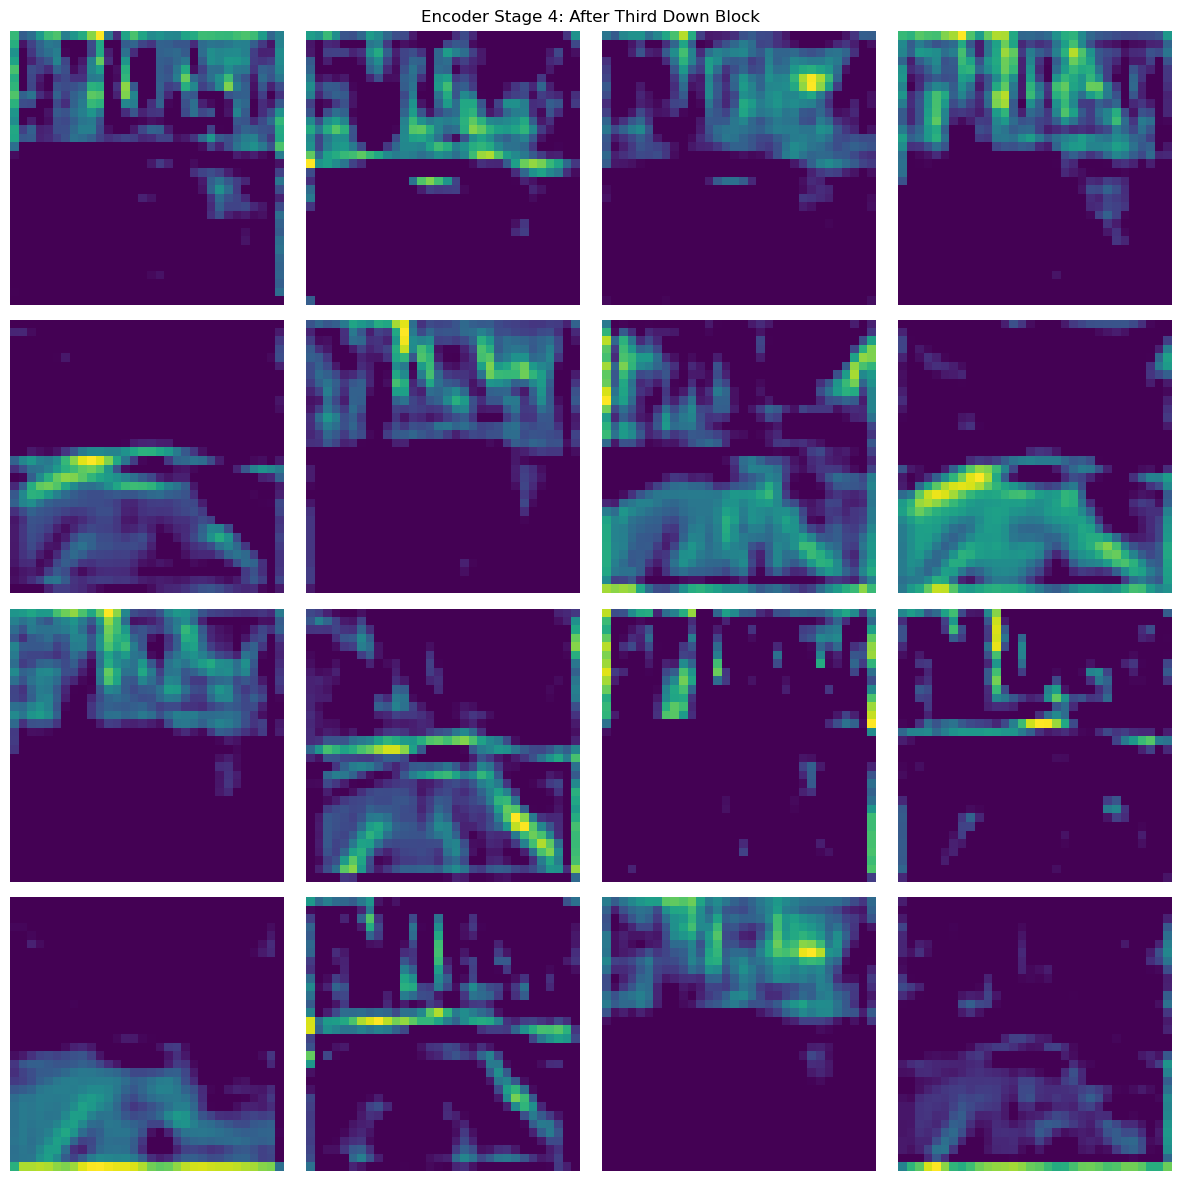

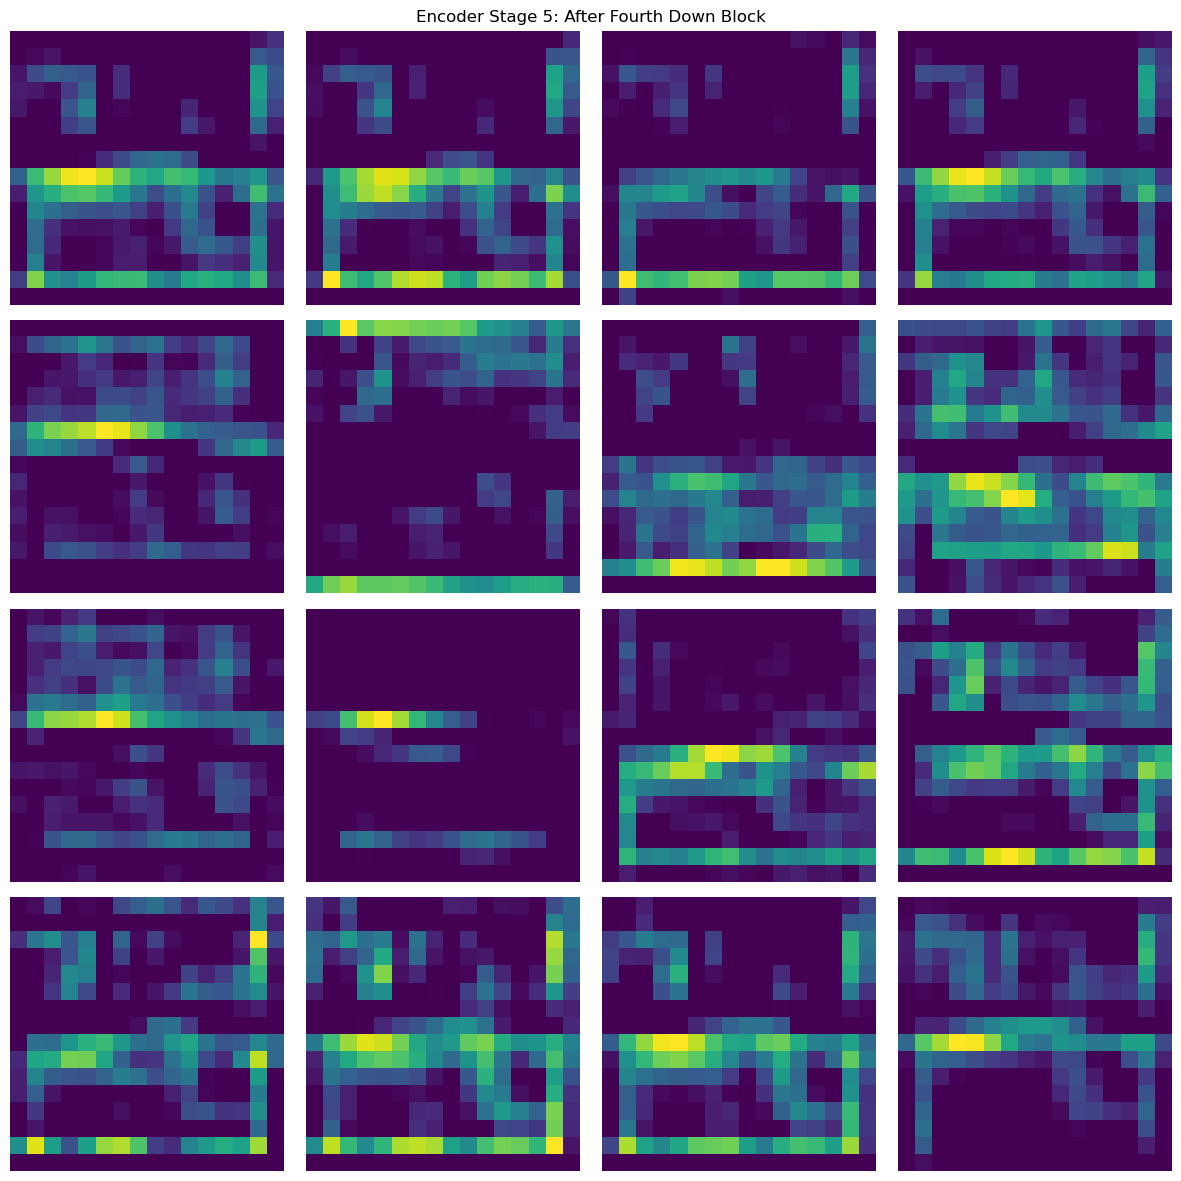

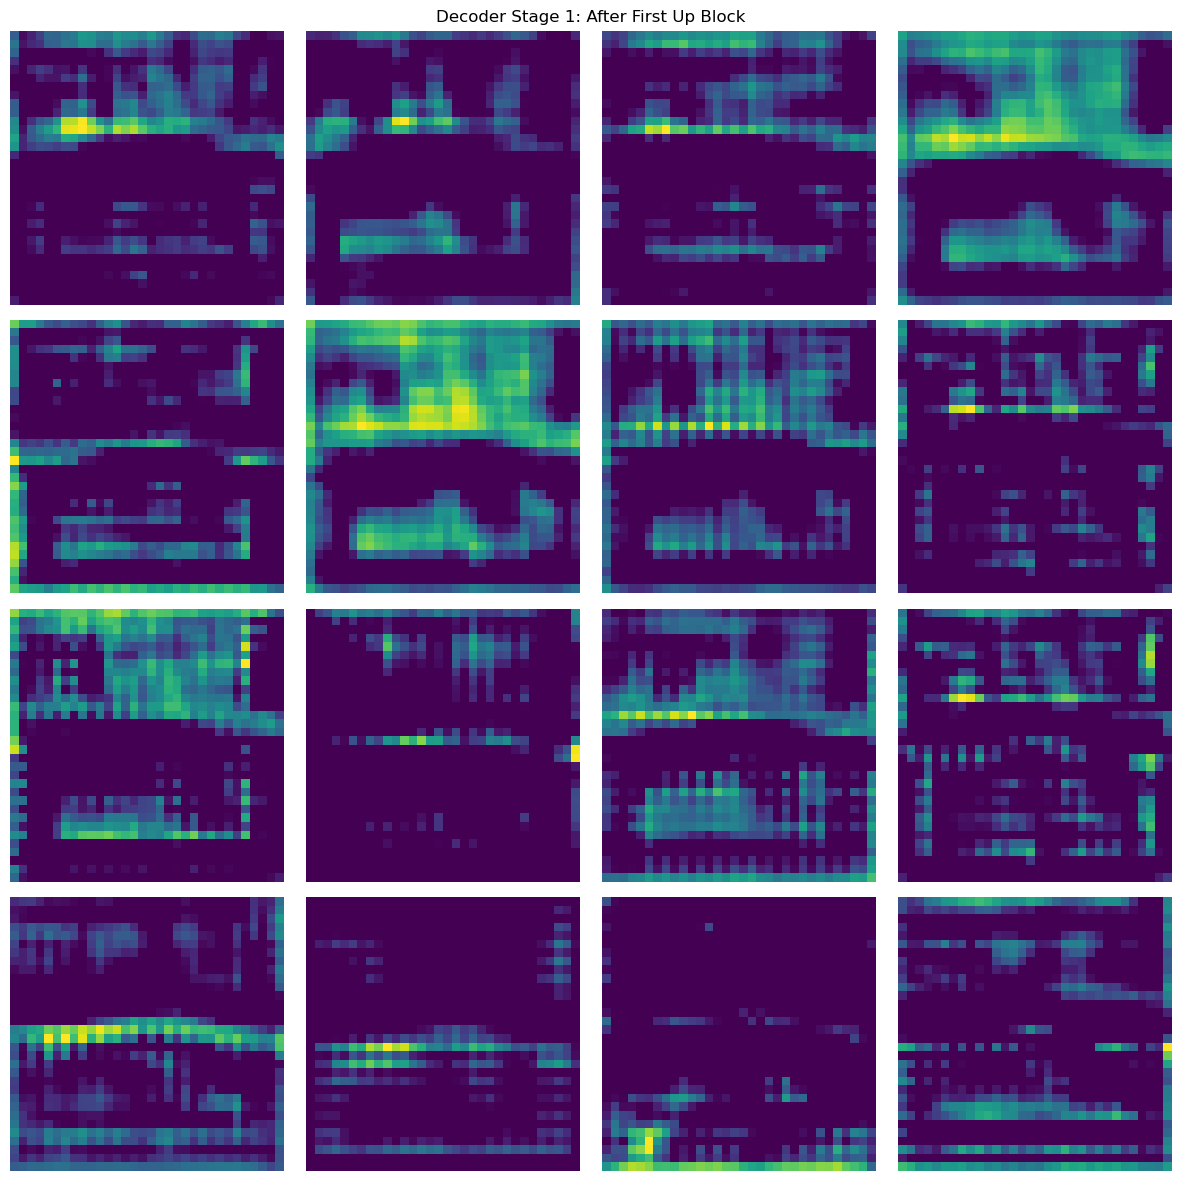

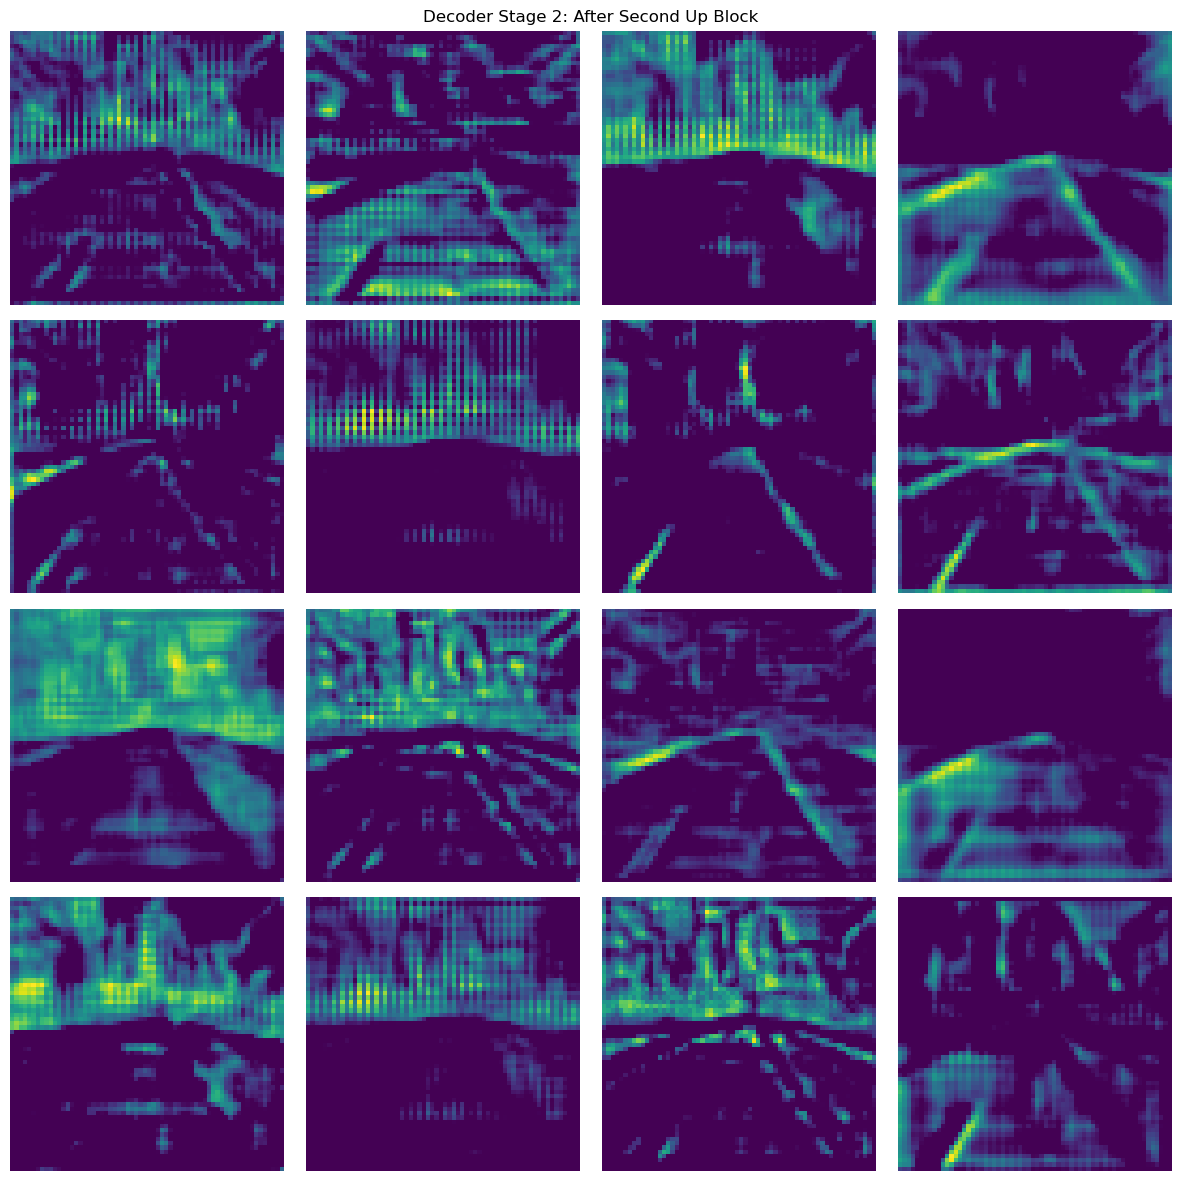

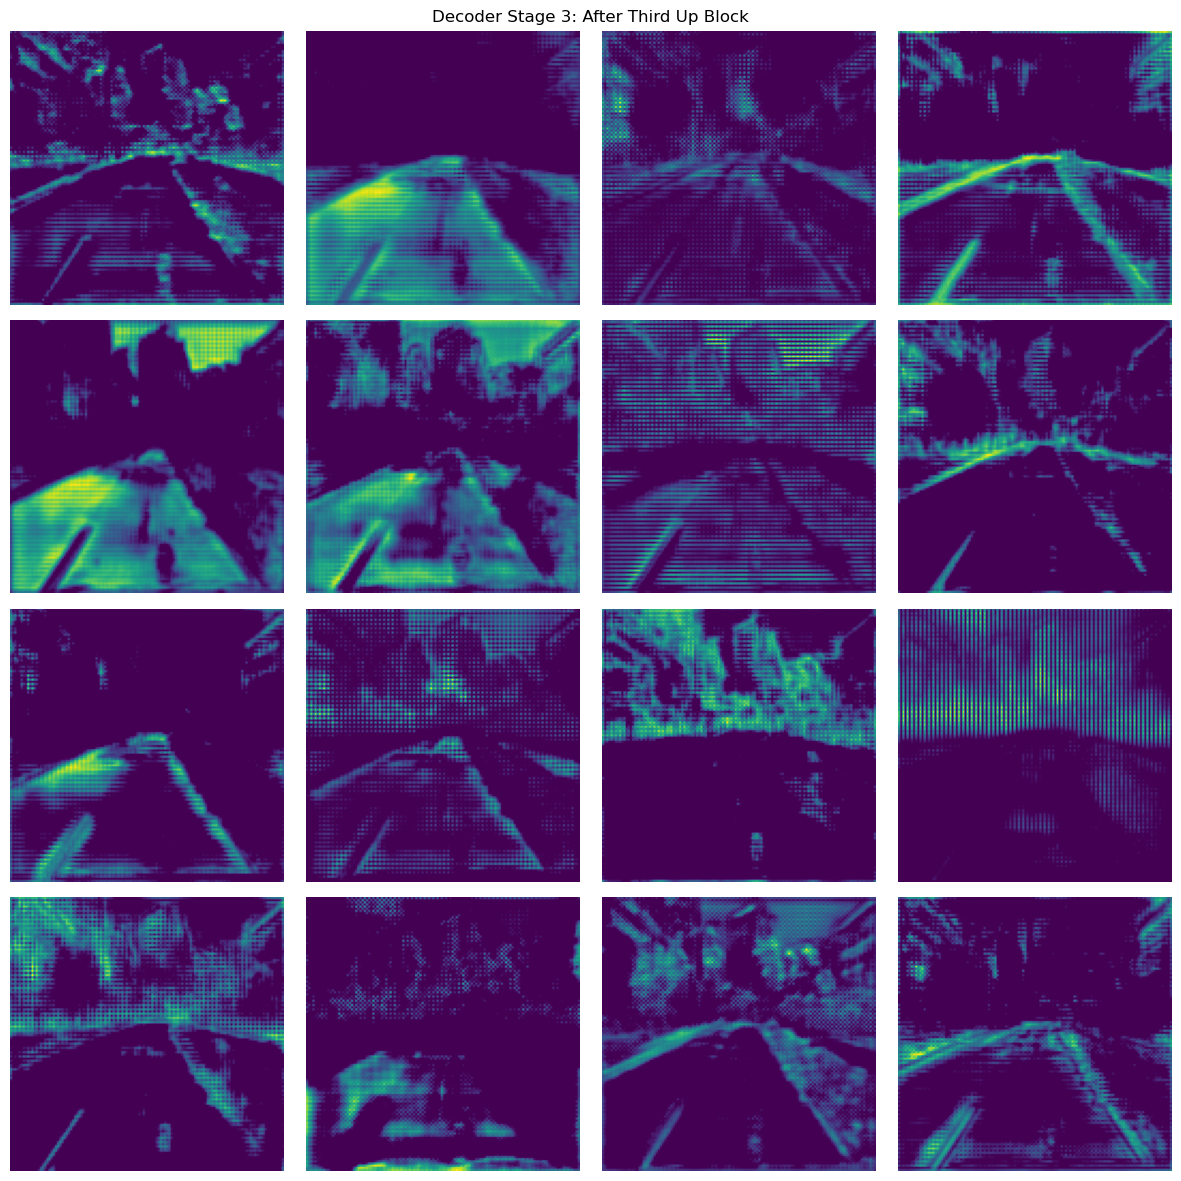

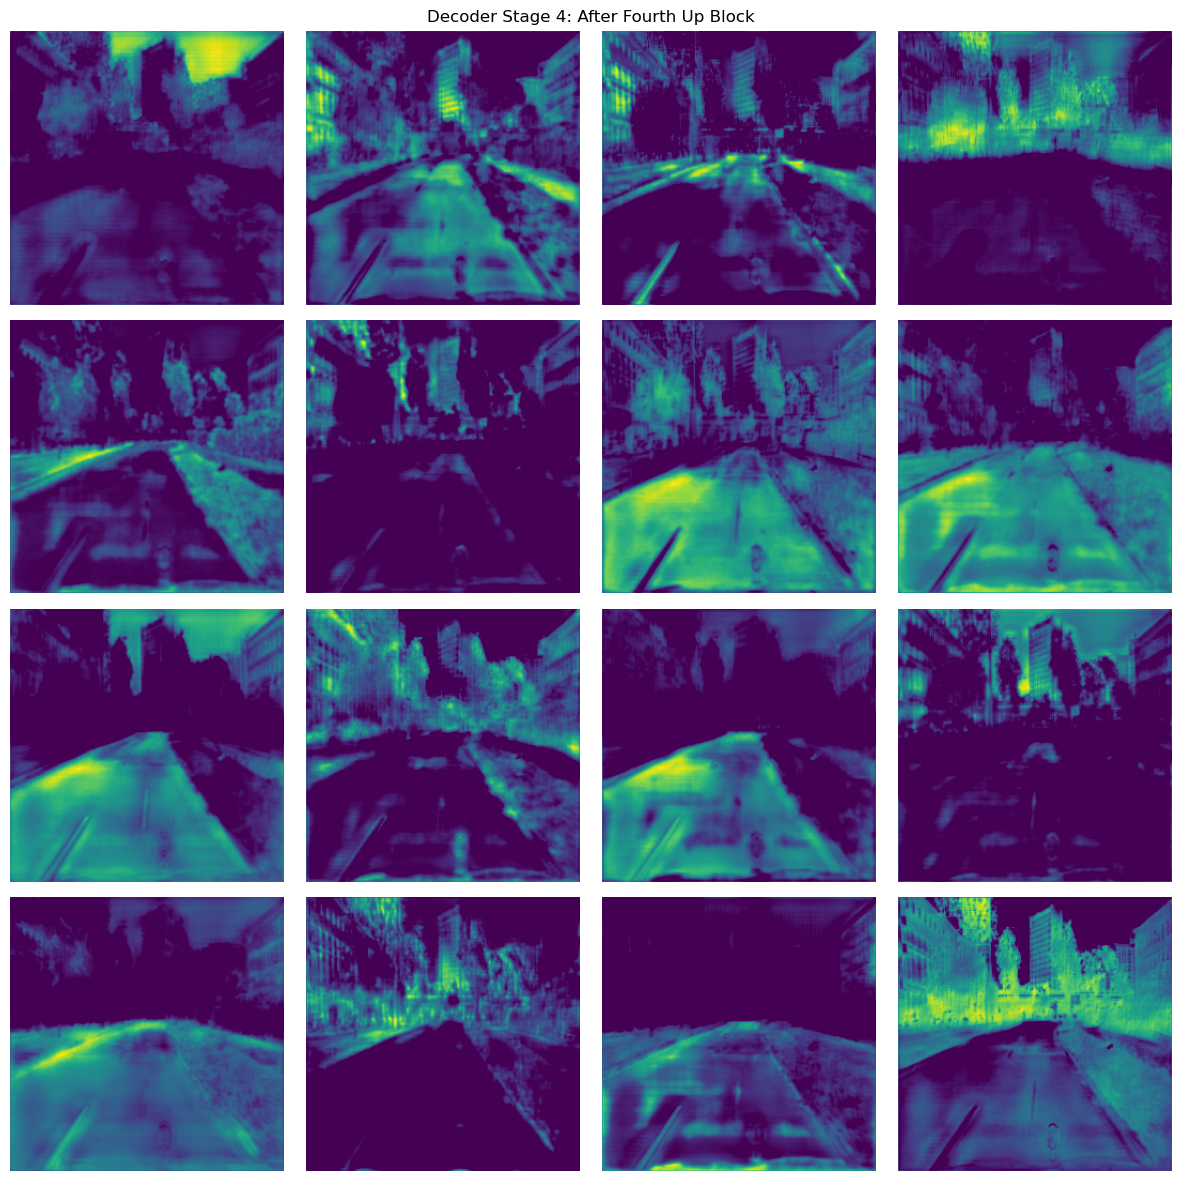

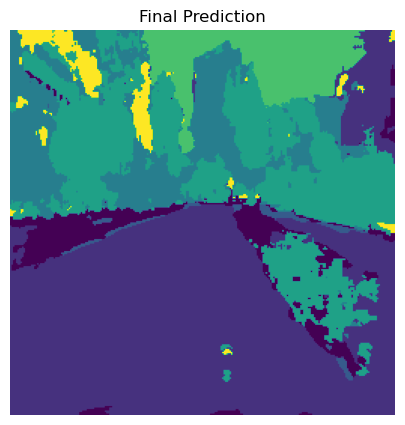

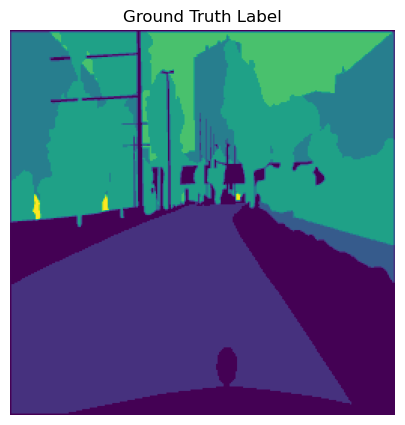

In [ ]:
# Inspect U-Net Model Outputs

import torch
import matplotlib.pyplot as plt
from models import UNet
from utils import load_data, N_CLASSES
from special_transforms import Compose, Resize, ToTensor
import numpy as np
import os

# Load the U-Net model
model = UNet(n_channels=3, n_classes=N_CLASSES)
model.load_state_dict(torch.load('unet.th'))  # Load pre-trained weights
model.eval()  # Set model to evaluation mode

# Adjust paths as needed
base_path = r"D:\Psych184B\SemanticSegmentationCityscapes"
relative_path = "small_dataset/train"
dataset_path = os.path.join(base_path, relative_path)

# Load the training dataset
train_data = load_data(dataset_path, num_workers=4, transform=Compose([Resize((256, 256)), ToTensor()]))

# Get a random instance from the training dataset
random_idx = torch.randint(0, len(train_data.dataset), (1,)).item()
image, label, mask = train_data.dataset[random_idx]

# Add batch dimension
image_batch = image.unsqueeze(0)

# Display the Original Image

plt.figure(figsize=(6,5))
img_np = image.permute(1, 2, 0).cpu().numpy()  # shape: [H, W, C]
plt.imshow(img_np)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Extract intermediate outputs from the U-Net model
with torch.no_grad():
    # Encoder outputs
    x1 = model.inc(image_batch)   # Initial convolution
    x2 = model.down1(x1)          # After first down block
    x3 = model.down2(x2)          # After second down block
    x4 = model.down3(x3)          # After third down block
    x5 = model.down4(x4)          # After fourth down block

    # Decoder outputs
    d1 = model.up1(x5, x4)        # After first up block
    d2 = model.up2(d1, x3)        # After second up block
    d3 = model.up3(d2, x2)        # After third up block
    d4 = model.up4(d3, x1)        # After fourth up block

    # Final output
    final_output = model(image_batch)

def visualize_feature_maps(feature_maps, title, max_maps=16):
    """
    Displays up to `max_maps` feature maps (channels) in a grid (4x4).
    feature_maps: Tensor of shape [B, C, H, W]
    title: Title for the entire figure
    max_maps: Max number of channels to visualize
    """
    # Take up to `max_maps` channels
    num_channels = min(feature_maps.shape[1], max_maps)

    # 4x4 grid (change to whatever layout you prefer, e.g., 2x8, etc.)
    num_rows, num_cols = 4, 4
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    fig.suptitle(title)

    # Flatten axes for easy indexing
    axes = axes.flatten()

    for i in range(num_rows * num_cols):
        ax = axes[i]
        if i < num_channels:
            # Show channel i
            ax.imshow(feature_maps[0, i].cpu().numpy(), cmap='viridis')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize encoder outputs (only 16 maps each)
visualize_feature_maps(x1, 'Encoder Stage 1: Initial Convolution')
visualize_feature_maps(x2, 'Encoder Stage 2: After First Down Block')
visualize_feature_maps(x3, 'Encoder Stage 3: After Second Down Block')
visualize_feature_maps(x4, 'Encoder Stage 4: After Third Down Block')
visualize_feature_maps(x5, 'Encoder Stage 5: After Fourth Down Block')

# Visualize decoder outputs (only 16 maps each)
visualize_feature_maps(d1, 'Decoder Stage 1: After First Up Block')
visualize_feature_maps(d2, 'Decoder Stage 2: After Second Up Block')
visualize_feature_maps(d3, 'Decoder Stage 3: After Third Up Block')
visualize_feature_maps(d4, 'Decoder Stage 4: After Fourth Up Block')

# Visualize final prediction
prediction = final_output.argmax(dim=1).squeeze().cpu().numpy()
plt.figure(figsize=(6, 5))
plt.imshow(prediction, cmap='viridis')
plt.title("Final Prediction")
plt.axis('off')
plt.show()

# Visualize ground truth
plt.figure(figsize=(6, 5))
plt.imshow(label.squeeze().cpu().numpy(), cmap='viridis')
plt.title("Ground Truth Label")
plt.axis('off')
plt.show()


# Sample Visualization of Prediction Results
This script performs a sample of semantic segmentation evaluation using the trained U-Net model and a test image. It computes several pixel-wise and region-wise metrics,such as IoU, Accuracy and ROM/RUM, and visualizes the input, ground truth, and predicted masks.


--- Per-Class IoU ---
unlabelled  : 0.0363
road        : 0.5339
sidewalk    : 0.2000
building    : 0.5772
vegetation  : 0.5749
sky         : 0.8503
person      : 0.0847
car         : 0.2231
Overall Mean IoU: 0.3851

--- Per-Class Accuracy ---
unlabelled  : 0.0376
road        : 0.5692
sidewalk    : 0.2228
building    : 0.9698
vegetation  : 0.7094
sky         : 0.9029
person      : 0.1230
car         : 0.4473
Overall Mean Accuracy: 0.4977

--- ROM / RUM ---
ROM (region-wise over-segmentation):  0.0994
RUM (region-wise under-segmentation): 0.2109



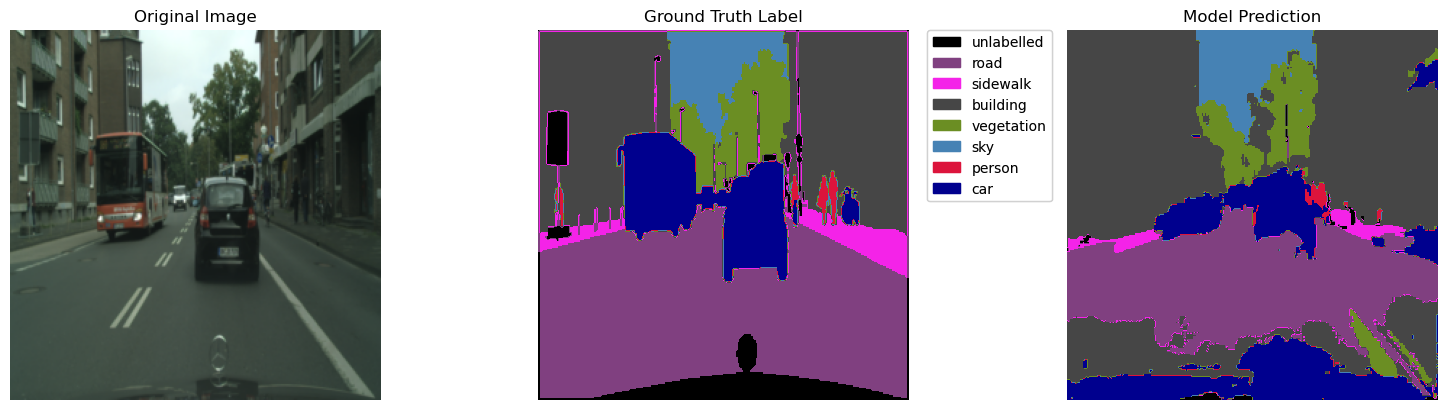

In [ ]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np
from special_transforms import Compose, Resize, ToTensor

from skimage.measure import label, regionprops
from skimage.transform import resize  # if not already imported

# --------------------------------------------------------------------------------
# 1) Define your class names and corresponding colors (RGB)
# --------------------------------------------------------------------------------
SELECT_LABEL_NAMES = [
    'unlabelled',
    'road',
    'sidewalk',
    'building',
    'vegetation',
    'sky',
    'person',
    'car'  # merged truck, bus, etc.
]
NUM_CLASSES = len(SELECT_LABEL_NAMES)

class_colors = [
    (0, 0, 0),        # 0: unlabelled
    (128, 64, 128),   # 1: road
    (244, 35, 232),   # 2: sidewalk
    (70, 70, 70),     # 3: building
    (107, 142, 35),   # 4: vegetation
    (70, 130, 180),   # 5: sky
    (220, 20, 60),    # 6: person
    (0, 0, 142),      # 7: car
]

seg_cmap = ListedColormap(np.array(class_colors) / 255.0)

def get_label_legend_patches():
    """Create one Patch (colored box) per class label for the legend."""
    patches = []
    for idx, label_name in enumerate(SELECT_LABEL_NAMES):
        color_float = np.array(class_colors[idx]) / 255.0
        patch = mpatches.Patch(color=color_float, label=label_name)
        patches.append(patch)
    return patches

# --------------------------------------------------------------------------------
# 2) Utility functions to compute metrics
# --------------------------------------------------------------------------------

def compute_classwise_iou(pred, gt, num_classes=NUM_CLASSES):
    """
    Compute IoU for each class for a single (pred, gt) pair.
    pred, gt: 2D numpy arrays [H, W], each in range [0, num_classes-1].
    Returns: list of IoU values per class (length num_classes).
    """
    pred_flat = pred.flatten()
    gt_flat = gt.flatten()
    ious = []
    for cls_id in range(num_classes):
        intersection = np.logical_and(pred_flat == cls_id, gt_flat == cls_id).sum()
        union = np.logical_or(pred_flat == cls_id, gt_flat == cls_id).sum()
        iou_val = intersection / (union + 1e-7)
        ious.append(iou_val)
    return ious

def compute_classwise_accuracy(pred, gt, num_classes=NUM_CLASSES):
    """
    Compute accuracy for each class for a single (pred, gt) pair.
    Returns: list of accuracy values per class.
    """
    pred_flat = pred.flatten()
    gt_flat = gt.flatten()
    accuracies = []
    for cls_id in range(num_classes):
        # Among all pixels that belong to 'cls_id' in ground truth,
        # how many did the prediction also label as 'cls_id'?
        mask_gt_cls = (gt_flat == cls_id)
        total_gt_cls = mask_gt_cls.sum()
        if total_gt_cls == 0:
            # If no pixels of this class exist in GT, define accuracy as 1.0 (or 0.0) by convention
            accuracies.append(1.0)
        else:
            correct_pred = np.logical_and(pred_flat == cls_id, mask_gt_cls).sum()
            acc_val = correct_pred / (total_gt_cls + 1e-7)
            accuracies.append(acc_val)
    return accuracies

def calculate_rom_rum(pred_mask, gt_mask):
    """
    Calculate ROM (Region-wise Over-segmentation Measure) and
    RUM (Region-wise Under-segmentation Measure).
    """
    if pred_mask.shape != gt_mask.shape:
        # Resize prediction to match ground truth
        pred_mask = resize(pred_mask, gt_mask.shape, order=0, preserve_range=True, anti_aliasing=False)
        pred_mask = pred_mask.astype(np.int32)

    # Label connected regions in predicted and ground truth masks
    pred_labels = label(pred_mask)
    gt_labels = label(gt_mask)

    over_seg_count = 0
    under_seg_count = 0

    # Over-segmentation: how many GT regions are overlapped by multiple pred regions?
    for region in regionprops(gt_labels):
        gt_region = (gt_labels == region.label)
        overlapping_preds = np.unique(pred_labels[gt_region])
        if len(overlapping_preds) > 1:
            over_seg_count += 1

    # Under-segmentation: how many pred regions overlap multiple GT regions?
    for region in regionprops(pred_labels):
        pred_region = (pred_labels == region.label)
        overlapping_gt = np.unique(gt_mask[pred_region])
        if len(overlapping_gt) > 1:
            under_seg_count += 1

    # Normalize by total # of regions
    unique_gt_regs = np.unique(gt_labels)
    unique_pred_regs = np.unique(pred_labels)
    # Subtract 1 if 0 is in the unique labels (since 0 often means background unlabeled region)
    if 0 in unique_gt_regs:
        total_gt_regions = len(unique_gt_regs) - 1
    else:
        total_gt_regions = len(unique_gt_regs)

    if 0 in unique_pred_regs:
        total_pred_regions = len(unique_pred_regs) - 1
    else:
        total_pred_regions = len(unique_pred_regs)

    rom = over_seg_count / (total_gt_regions + 1e-7) if total_gt_regions > 0 else 0.0
    rum = under_seg_count / (total_pred_regions + 1e-7) if total_pred_regions > 0 else 0.0

    return rom, rum

# --------------------------------------------------------------------------------
# 3) Load your test data (adapt path & transforms as needed)
# --------------------------------------------------------------------------------
test_path = r"D:\Psych184B\SemanticSegmentationCityscapes\small_dataset\test"
test_data = load_data(
    test_path, 
    num_workers=4, 
    batch_size=1,
    transform=Compose([Resize((256, 256)), ToTensor()])
)

# Now this should work with a dataset of size 1:
test_iter = iter(test_data)
images, labels, masks = next(test_iter)  # single item batch

model.eval()
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# We'll compute metrics for the single item `idx=0`
idx = 0
img_np = images[idx].permute(1, 2, 0).cpu().numpy()  # [H, W, C]
label_np = labels[idx].cpu().numpy()                 # [H, W]
pred_np = preds[idx].cpu().numpy()                   # [H, W]

# --------------------------------------------------------------------------------
# 4) Compute and Print Classwise Metrics & ROM/RUM
# --------------------------------------------------------------------------------
# (A) Classwise IoU
class_iou = compute_classwise_iou(pred_np, label_np, num_classes=NUM_CLASSES)
mean_iou = np.mean(class_iou)

# (B) Classwise Accuracy
class_acc = compute_classwise_accuracy(pred_np, label_np, num_classes=NUM_CLASSES)
mean_acc = np.mean(class_acc)

# (C) ROM and RUM
rom, rum = calculate_rom_rum(pred_np, label_np)

print("\n--- Per-Class IoU ---")
for cls_id, iou_val in enumerate(class_iou):
    print(f"{SELECT_LABEL_NAMES[cls_id]:12s}: {iou_val:.4f}")
print(f"Overall Mean IoU: {mean_iou:.4f}")

print("\n--- Per-Class Accuracy ---")
for cls_id, acc_val in enumerate(class_acc):
    print(f"{SELECT_LABEL_NAMES[cls_id]:12s}: {acc_val:.4f}")
print(f"Overall Mean Accuracy: {mean_acc:.4f}")

print("\n--- ROM / RUM ---")
print(f"ROM (region-wise over-segmentation):  {rom:.4f}")
print(f"RUM (region-wise under-segmentation): {rum:.4f}\n")

# --------------------------------------------------------------------------------
# 5) Visualization
# --------------------------------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# (A) Original Image
ax1.imshow(img_np)
ax1.set_title("Original Image")
ax1.axis('off')

# (B) Ground Truth (with legend)
ax2.imshow(label_np, cmap=seg_cmap, vmin=0, vmax=len(SELECT_LABEL_NAMES)-1)
ax2.set_title("Ground Truth Label")
ax2.axis('off')
gt_patches = get_label_legend_patches()
gt_legend = ax2.legend(handles=gt_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax2.add_artist(gt_legend)

# (C) Prediction (with legend)
ax3.imshow(pred_np, cmap=seg_cmap, vmin=0, vmax=len(SELECT_LABEL_NAMES)-1)
ax3.set_title("Model Prediction")
ax3.axis('off')
pred_patches = get_label_legend_patches()
pred_legend = ax3.legend(handles=pred_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax3.add_artist(pred_legend)

plt.tight_layout()
plt.show()


# Data Visualization
The following scripts visualize the statistical results from our semantic segmentation evaluations, highlighting the impact of various feature modifications and parameter tuning strategies.

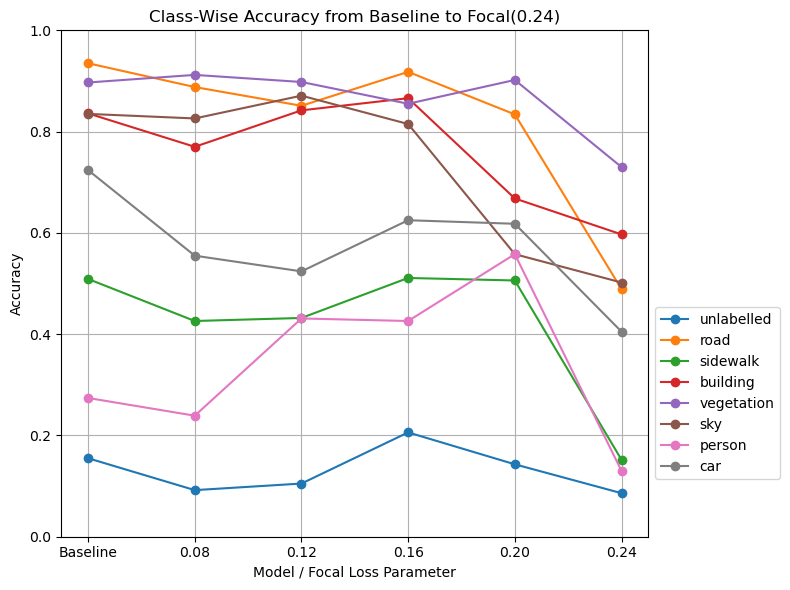

In [110]:
import matplotlib.pyplot as plt
import numpy as np

# x-axis: model configurations
models = ["Baseline", "0.08", "0.12", "0.16", "0.20", "0.24"]

# Example class-accuracy values for each model (rows = models, columns = classes)
# Replace these with your actual numbers from the screenshots:

acc_unlabelled = [0.155, 0.092, 0.105, 0.206, 0.143, 0.086]
acc_road       = [0.935, 0.888, 0.851, 0.918, 0.834, 0.489]
acc_sidewalk   = [0.509, 0.426, 0.432, 0.511, 0.506, 0.152]
acc_building   = [0.836, 0.770, 0.842, 0.866, 0.668, 0.597]
acc_vegetation = [0.897, 0.912, 0.898, 0.855, 0.902, 0.730]
acc_sky        = [0.835, 0.826, 0.871, 0.815, 0.558, 0.502]
acc_person     = [0.274, 0.239, 0.431, 0.426, 0.558, 0.130]
acc_car        = [0.724, 0.555, 0.524, 0.625, 0.618, 0.405]

# 2) Plot each class's accuracy as a separate line
plt.figure(figsize=(8,6))

plt.plot(models, acc_unlabelled, marker='o', label='unlabelled')
plt.plot(models, acc_road,       marker='o', label='road')
plt.plot(models, acc_sidewalk,   marker='o', label='sidewalk')
plt.plot(models, acc_building,   marker='o', label='building')
plt.plot(models, acc_vegetation, marker='o', label='vegetation')
plt.plot(models, acc_sky,        marker='o', label='sky')
plt.plot(models, acc_person,     marker='o', label='person')
plt.plot(models, acc_car,        marker='o', label='car')

plt.title("Class-Wise Accuracy from Baseline to Focal(0.24)")
plt.xlabel("Model / Focal Loss Parameter")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Because accuracy is between 0 and 1
plt.grid(True)
plt.legend(loc='lower left', bbox_to_anchor=(1.0, 0.1))  # put legend outside if desired
plt.tight_layout()
plt.show()


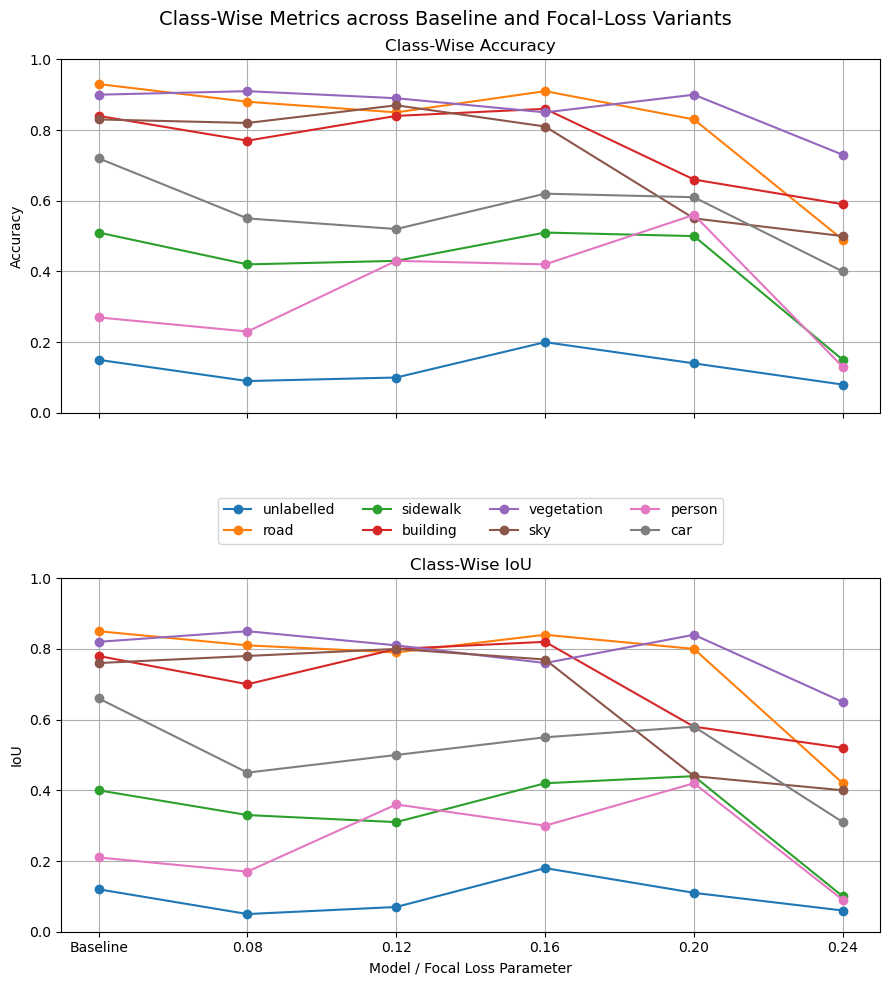

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# 6 models / configurations in the order you tested
models = ["Baseline", "0.08", "0.12", "0.16", "0.20", "0.24"]

# ----------------------------------------------------------------------
# 1) Class-wise Accuracy (replace these with YOUR real accuracy data!)
# ----------------------------------------------------------------------
acc_unlabelled = [0.15, 0.09, 0.10, 0.20, 0.14, 0.08]
acc_road       = [0.93, 0.88, 0.85, 0.91, 0.83, 0.49]
acc_sidewalk   = [0.51, 0.42, 0.43, 0.51, 0.50, 0.15]
acc_building   = [0.84, 0.77, 0.84, 0.86, 0.66, 0.59]
acc_vegetation = [0.90, 0.91, 0.89, 0.85, 0.90, 0.73]
acc_sky        = [0.83, 0.82, 0.87, 0.81, 0.55, 0.50]
acc_person     = [0.27, 0.23, 0.43, 0.42, 0.56, 0.13]
acc_car        = [0.72, 0.55, 0.52, 0.62, 0.61, 0.40]

# ----------------------------------------------------------------------
# 2) Class-wise IoU (replace these with YOUR real IoU data!)
# ----------------------------------------------------------------------
iou_unlabelled = [0.12, 0.05, 0.07, 0.18, 0.11, 0.06]
iou_road       = [0.85, 0.81, 0.79, 0.84, 0.80, 0.42]
iou_sidewalk   = [0.40, 0.33, 0.31, 0.42, 0.44, 0.10]
iou_building   = [0.78, 0.70, 0.80, 0.82, 0.58, 0.52]
iou_vegetation = [0.82, 0.85, 0.81, 0.76, 0.84, 0.65]
iou_sky        = [0.76, 0.78, 0.80, 0.77, 0.44, 0.40]
iou_person     = [0.21, 0.17, 0.36, 0.30, 0.42, 0.09]
iou_car        = [0.66, 0.45, 0.50, 0.55, 0.58, 0.31]

# We'll collect our classes in a dict to loop over for plotting:
class_labels = [
    "unlabelled", "road", "sidewalk", "building", 
    "vegetation", "sky", "person", "car"
]
acc_data = [
    acc_unlabelled, acc_road, acc_sidewalk, acc_building,
    acc_vegetation, acc_sky, acc_person, acc_car
]
iou_data = [
    iou_unlabelled, iou_road, iou_sidewalk, iou_building,
    iou_vegetation, iou_sky, iou_person, iou_car
]

# ----------------------------------------------------------------------
# 3) Plot
# ----------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 10), sharex=True)
plt.suptitle("Class-Wise Metrics across Baseline and Focal-Loss Variants", fontsize=14)

# === Accuracy subplot ===
for label, acc_values in zip(class_labels, acc_data):
    ax1.plot(models, acc_values, marker='o', label=label)

ax1.set_title("Class-Wise Accuracy")
ax1.set_ylabel("Accuracy")
ax1.set_ylim(0, 1)
ax1.grid(True)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.22), ncol=4)  # move legend below if you like
ax1.set_xticks(models)  # ensures we see all model labels

# === IoU subplot ===
for label, iou_values in zip(class_labels, iou_data):
    ax2.plot(models, iou_values, marker='o', label=label)

ax2.set_title("Class-Wise IoU")
ax2.set_xlabel("Model / Focal Loss Parameter")
ax2.set_ylabel("IoU")
ax2.set_ylim(0, 1)
ax2.grid(True)
ax2.set_xticks(models)

# If you'd rather have a separate legend for IoU, uncomment the following:
# ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4)

plt.tight_layout()
plt.show()


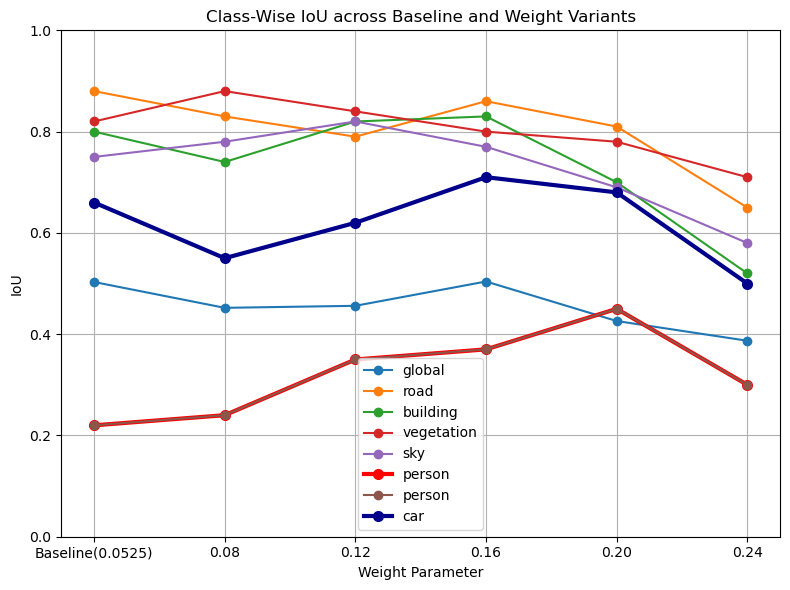

In [175]:
import matplotlib.pyplot as plt

# 1) Model settings on the x-axis
models = ["Baseline(0.0525)", "0.08", "0.12", "0.16", "0.20", "0.24"]

# 2) Class labels
class_labels = [
     "global","road",  "building", 
    "vegetation", "sky", "person", "car"
]

# 3) Example IoU values across the 6 models (fake data!)
#    Replace these with your real IoU results.
iou_global     = [0.503,0.452,0.456,0.504,0.426,0.387]
iou_unlabelled = [0.10, 0.12, 0.11, 0.13, 0.12, 0.09]
iou_road       = [0.88, 0.83, 0.79, 0.86, 0.81, 0.65]
iou_sidewalk   = [0.35, 0.31, 0.40, 0.45, 0.42, 0.28]
iou_building   = [0.80, 0.74, 0.82, 0.83, 0.70, 0.52]
iou_vegetation = [0.82, 0.88, 0.84, 0.80, 0.78, 0.71]
iou_sky        = [0.75, 0.78, 0.82, 0.77, 0.69, 0.58]
iou_person     = [0.22, 0.24, 0.35, 0.37, 0.45, 0.30]  # highlight this!
iou_car        = [0.66, 0.55, 0.62, 0.71, 0.68, 0.50]

# Collect the IoU data in the same order as class_labels
iou_data = [
    iou_global,iou_road, iou_building,
    iou_vegetation, iou_sky, iou_person, iou_car
]

# 4) Plot the lines, highlighting "person"
fig, ax = plt.subplots(figsize=(8, 6))

for label, iou_values in zip(class_labels, iou_data):
    if label == "person":
        # Make "person" thicker, bigger markers, different color
        ax.plot(
            models, iou_values,
            marker='o',
            linewidth=3,
            markersize=7,
            color='red',
            label=label
        )
    if label == "car":
        # Make "person" thicker, bigger markers, different color
        ax.plot(
            models, iou_values,
            marker='o',
            linewidth=3,
            markersize=7,
            color='darkblue',
            label=label
        )
    else:
        ax.plot(
            models, iou_values,
            marker='o',
            label=label
        )

ax.set_title("Class-Wise IoU across Baseline and Weight Variants")
ax.set_xlabel("Weight Parameter")
ax.set_ylabel("IoU")
ax.set_ylim([0, 1])   # IoU ranges from 0 to 1
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


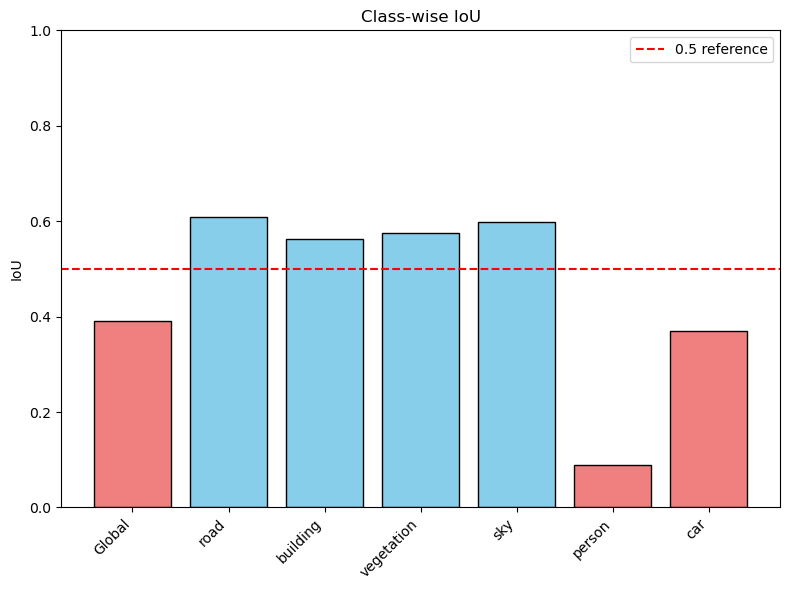

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Define your classes and IoU values
class_labels = ["Global","road", "building", "vegetation", "sky", "person", "car"]
iou_values = [0.39,0.608, 0.563, 0.576, 0.599, 0.089, 0.369]

# 2) Create a color list based on IoU < 0.5
colors = []
for val in iou_values:
    if val < 0.5:
        colors.append("lightcoral")  # "light red"
    else:
        colors.append("skyblue")     # original color

# 3) Create a bar plot
plt.figure(figsize=(8, 6))
x_positions = np.arange(len(class_labels))

plt.bar(x_positions, iou_values, color=colors, edgecolor='black')

# 4) Add a horizontal reference line at 0.5
plt.axhline(y=0.5, color='red', linestyle='--', label='0.5 reference')

# 5) Configure axes, labels, and legend
plt.xticks(x_positions, class_labels, rotation=45, ha='right')
plt.ylabel("IoU")
plt.ylim(0, 1.0)
plt.title("Class-wise IoU")
plt.legend()

plt.tight_layout()
plt.show()


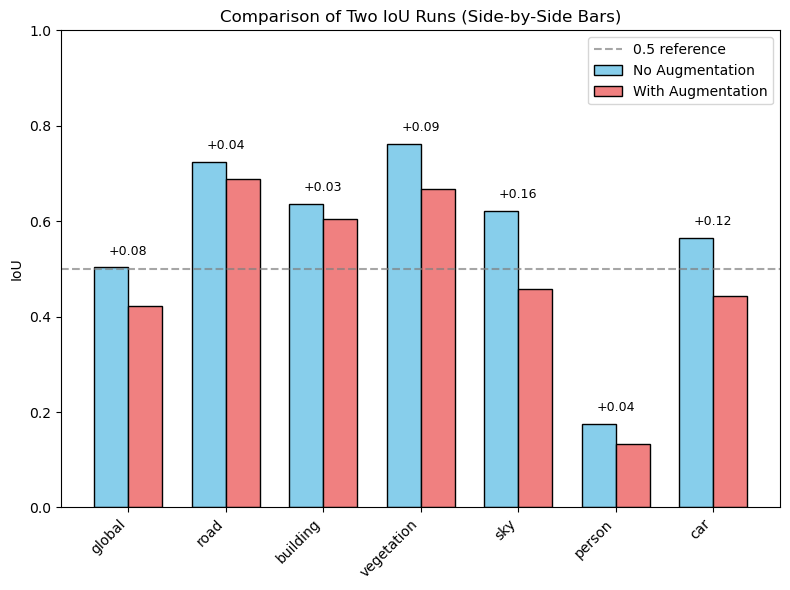

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Classes in the same order for both runs
class_labels = [
    "global",    # mean IoU (from summary)
    "road",
    "building",
    "vegetation",
    "sky",
    "person",
    "car"
]

# 2) IoU values from the higher-IoU run (mean IoU ~ 0.503)
high_iou = [
    0.503,  # global
    0.725,  # road
    0.637,  # building
    0.762,  # vegetation
    0.622,  # sky
    0.175,  # person
    0.565   # car
]

# 3) IoU values from the lower-IoU run (mean IoU ~ 0.422)
low_iou = [
    0.422,  # global
    0.689,  # road
    0.604,  # building
    0.668,  # vegetation
    0.457,  # sky
    0.133,  # person
    0.444   # car
]

# 4) Make side-by-side bar plots
x_positions = np.arange(len(class_labels))
width = 0.35  # how wide each bar is

plt.figure(figsize=(8, 6))

# Left bars (high IoU)
plt.bar(
    x_positions - width/2, high_iou,
    width=width, color='skyblue',
    edgecolor='black', label='No Augmentation'
)

# Right bars (low IoU)
plt.bar(
    x_positions + width/2, low_iou,
    width=width, color='lightcoral',
    edgecolor='black', label='With Augmentation'
)

# 5) Add a horizontal reference line at IoU=0.5
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='0.5 reference')

# 6) Annotate the difference above each pair
for i, (hi, lo) in enumerate(zip(high_iou, low_iou)):
    diff = hi - lo
    # Place the text above whichever bar is taller
    y_pos = max(hi, lo) + 0.02
    # x-position in between the two bars
    x_pos = x_positions[i]
    # Show + or - sign (e.g. +0.03, -0.12)
    plt.text(x_pos, y_pos, f"{diff:+.2f}", ha='center', va='bottom', fontsize=9)

# 7) Cosmetics: x-ticks, labels, legend, etc.
plt.xticks(x_positions, class_labels, rotation=45, ha='right')
plt.ylabel("IoU")
plt.ylim([0, 1.0])
plt.title("Comparison of Two IoU Runs (Side-by-Side Bars)")

plt.legend()
plt.tight_layout()
plt.show()


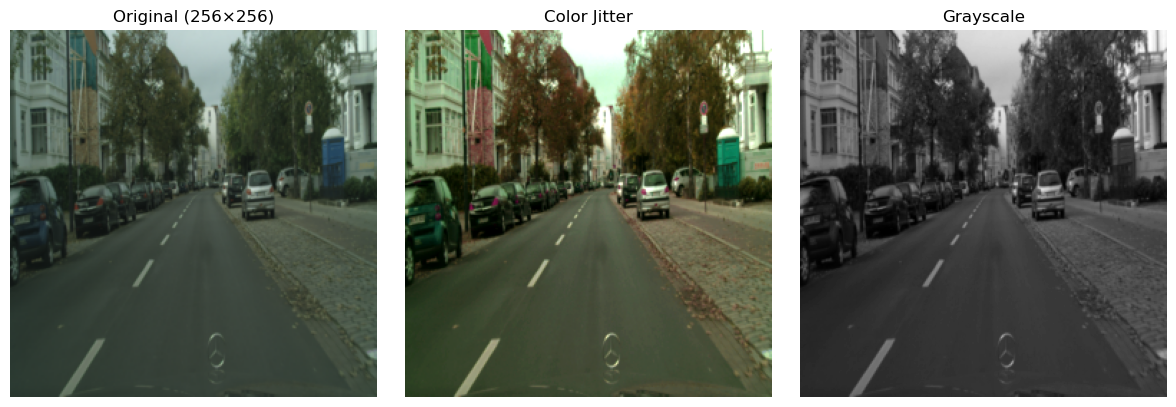

In [2]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

# 1) Specify the directory containing your images
IMG_DIR = r"D:\Psych184B\SemanticSegmentationCityscapes\small_dataset\train"

# 2) Collect all JPEG/PNG files in that directory
img_files = [
    f for f in os.listdir(IMG_DIR) 
    if f.lower().endswith(".jpg") or f.lower().endswith(".png")
]

# 3) Pick a random image file
random_img_file = random.choice(img_files)
img_path = os.path.join(IMG_DIR, random_img_file)

# 4) Load the image with PIL
img = Image.open(img_path).convert("RGB")

# 5) Define transformations
resizer = T.Resize((256, 256))
color_jitter = T.ColorJitter(
    brightness=0.5, 
    contrast=0.5, 
    saturation=0.5, 
    hue=0.2
)
to_gray = T.Grayscale(num_output_channels=1)

# 6) Apply transforms
# First resize
img_resized = resizer(img)

# Then color jitter
img_jittered = color_jitter(img_resized)

# Then grayscale
img_gray = to_gray(img_resized)

# 7) Plot all three
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.imshow(img_resized)
ax1.set_title("Original (256×256)")
ax1.axis('off')

ax2.imshow(img_jittered)
ax2.set_title("Color Jitter")
ax2.axis('off')

ax3.imshow(img_gray, cmap='gray')
ax3.set_title("Grayscale")
ax3.axis('off')

plt.tight_layout()
plt.show()


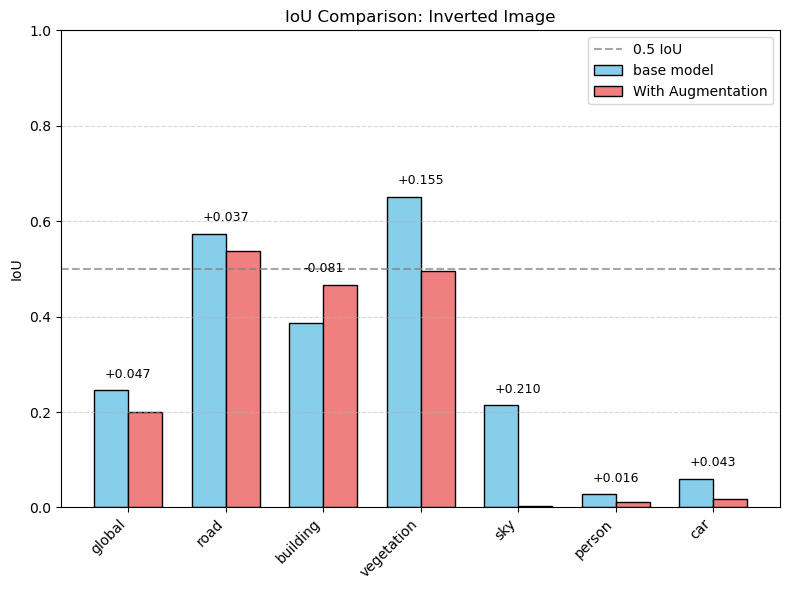

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Classes: dropped "unlabelled" & "sidewalk", added "global"
class_labels = [
    "global",
    "road",
    "building",
    "vegetation",
    "sky",
    "person",
    "car"
]

# 2) FIRST screenshot IoU
#    Originally: [unlabelled=0.042, road=0.574, sidewalk=0.013, building=0.386, 
#                vegetation=0.651, sky=0.214, person=0.028, car=0.060]
#    We remove indices for unlabelled (0) & sidewalk (2),
#    then prepend the global IoU (0.246) at the front:
run1_iou = [
    0.246,  # global IoU
    0.574,  # road
    0.386,  # building
    0.651,  # vegetation
    0.214,  # sky
    0.028,  # person
    0.060   # car
]

# 3) SECOND screenshot IoU
#    Originally: [unlabelled=0.048, road=0.537, sidewalk=0.014, building=0.467,
#                vegetation=0.496, sky=0.004, person=0.012, car=0.017]
#    Remove unlabelled (0) & sidewalk (2), 
#    prepend global IoU (0.199) at the front:
run2_iou = [
    0.199,  # global IoU
    0.537,  # road
    0.467,  # building
    0.496,  # vegetation
    0.004,  # sky
    0.012,  # person
    0.017   # car
]

# 4) Create side-by-side bar plots
x_positions = np.arange(len(class_labels))
bar_width = 0.35

plt.figure(figsize=(8, 6))

# Left bars (First screenshot)
plt.bar(
    x_positions - bar_width / 2,
    run1_iou,
    width=bar_width,
    color='skyblue',
    edgecolor='black',
    label='base model'
)

# Right bars (Second screenshot)
plt.bar(
    x_positions + bar_width / 2,
    run2_iou,
    width=bar_width,
    color='lightcoral',
    edgecolor='black',
    label='With Augmentation'
)

# 5) Add a horizontal line at 0.5 IoU for reference
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='0.5 IoU')

# 6) Annotate the difference above each pair
for i, (r1, r2) in enumerate(zip(run1_iou, run2_iou)):
    diff = r1 - r2
    top_bar_height = max(r1, r2)
    y_pos = top_bar_height + 0.02
    x_pos = x_positions[i]
    # Show difference with sign and 3 decimal places
    plt.text(
        x_pos, y_pos,
        f"{diff:+.3f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

# 7) Cosmetic details
plt.xticks(x_positions, class_labels, rotation=45, ha='right')
plt.ylabel("IoU")
plt.ylim([0, 1.0])
plt.title("IoU Comparison: Inverted Image")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



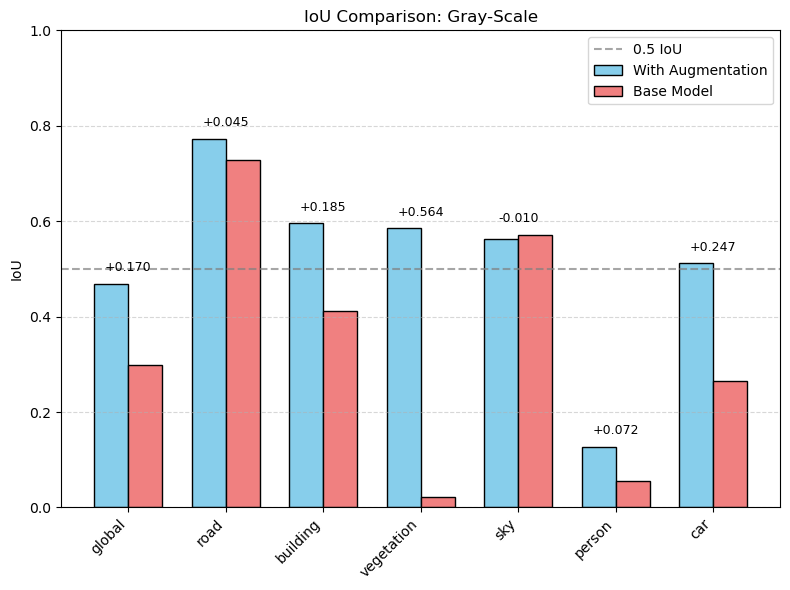

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Classes: 
#    - Dropped "unlabelled" & "sidewalk"
#    - Added "global" at the front
class_labels = [
    "global",
    "road",
    "building",
    "vegetation",
    "sky",
    "person",
    "car"
]

# 2) FIRST screenshot IoU
#    unlabelled=0.324, road=0.773, sidewalk=0.276, building=0.596, 
#    vegetation=0.585, sky=0.562, person=0.127, car=0.512
#    Mean IoU=0.469
#    We skip unlabelled and sidewalk, then prepend global=0.469 at the start:
run1_iou = [
    0.469,  # global
    0.773,  # road
    0.596,  # building
    0.585,  # vegetation
    0.562,  # sky
    0.127,  # person
    0.512   # car
]

# 3) SECOND screenshot IoU
#    unlabelled=0.299, road=0.728, sidewalk=0.043, building=0.411,
#    vegetation=0.021, sky=0.572, person=0.055, car=0.265
#    Mean IoU=0.299
#    Again, skip unlabelled & sidewalk, then prepend global=0.299
run2_iou = [
    0.299,  # global
    0.728,  # road
    0.411,  # building
    0.021,  # vegetation
    0.572,  # sky
    0.055,  # person
    0.265   # car
]

# 4) Make side-by-side bar plots
x_positions = np.arange(len(class_labels))
bar_width = 0.35

plt.figure(figsize=(8, 6))

# Left bars (First screenshot)
plt.bar(
    x_positions - bar_width / 2,
    run1_iou,
    width=bar_width,
    color='skyblue',
    edgecolor='black',
    label='With Augmentation'
)

# Right bars (Second screenshot)
plt.bar(
    x_positions + bar_width / 2,
    run2_iou,
    width=bar_width,
    color='lightcoral',
    edgecolor='black',
    label='Base Model'
)

# 5) Add a horizontal line at 0.5 for reference
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='0.5 IoU')

# 6) Annotate the difference above each pair
for i, (r1, r2) in enumerate(zip(run1_iou, run2_iou)):
    diff = r1 - r2
    top_bar_height = max(r1, r2)
    y_pos = top_bar_height + 0.02
    x_pos = x_positions[i]
    plt.text(
        x_pos, y_pos,
        f"{diff:+.3f}",  # e.g. +0.123 or -0.045
        ha='center',
        va='bottom',
        fontsize=9
    )

# 7) Cosmetics
plt.xticks(x_positions, class_labels, rotation=45, ha='right')
plt.ylabel("IoU")
plt.ylim([0, 1.0])
plt.title("IoU Comparison: Gray-Scale")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
